In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
%matplotlib inline
plt.style.use('bmh')

In [21]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization

In [22]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, explode, split, year, month, dayofweek, length, initcap, trim, lower, 
    regexp_extract, regexp_replace, max, explode, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [23]:
spark = SparkSession.builder \
    .appName("Cleaned Data EDA") \
    .getOrCreate()

spark

24/10/27 14:47:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [24]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [25]:
def get_null_counts(df):
    """
    Get counts and percentages of null values in each column of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to analyze.

    Returns:
    DataFrame: A DataFrame containing column names, null counts, and null percentages.
    """
    total_rows = df.count()
    
    null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])

    narrow_null_counts = null_counts.selectExpr(
                                    f"'{null_counts.columns[0]}' as column_name",
                                    f"{null_counts.columns[0]} as null_count",
                                    f"({null_counts.columns[0]} / {total_rows} * 100) as null_percentage")

    for c in null_counts.columns[1:]:
        next_col = null_counts.selectExpr(f"'{c}' as column_name", 
                                          f"{c} as null_count",
                                          f"({c} / {total_rows} * 100) as null_percentage")
        narrow_null_counts = narrow_null_counts.union(next_col)
    
    narrow_null_counts = narrow_null_counts.orderBy(desc("null_count"))
    
    return narrow_null_counts

In [26]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

In [27]:
narrow_null_counts = get_null_counts(ip_data)
narrow_null_counts.show(n=5, truncate=False)

+-------------------------------------+----------+---------------+
|column_name                          |null_count|null_percentage|
+-------------------------------------+----------+---------------+
|city_or_county                       |0         |0.0            |
|participant_status_injured_freq      |0         |0.0            |
|participant_type_subject_suspect_freq|0         |0.0            |
|participant_status_unharmed_freq     |0         |0.0            |
|participant_type_victim_freq         |0         |0.0            |
+-------------------------------------+----------+---------------+
only showing top 5 rows



#### Visualizations

In [29]:
pandas_ip_df = ip_data.toPandas()

24/10/27 14:47:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [30]:
visualization = Visualization(pandas_ip_df)

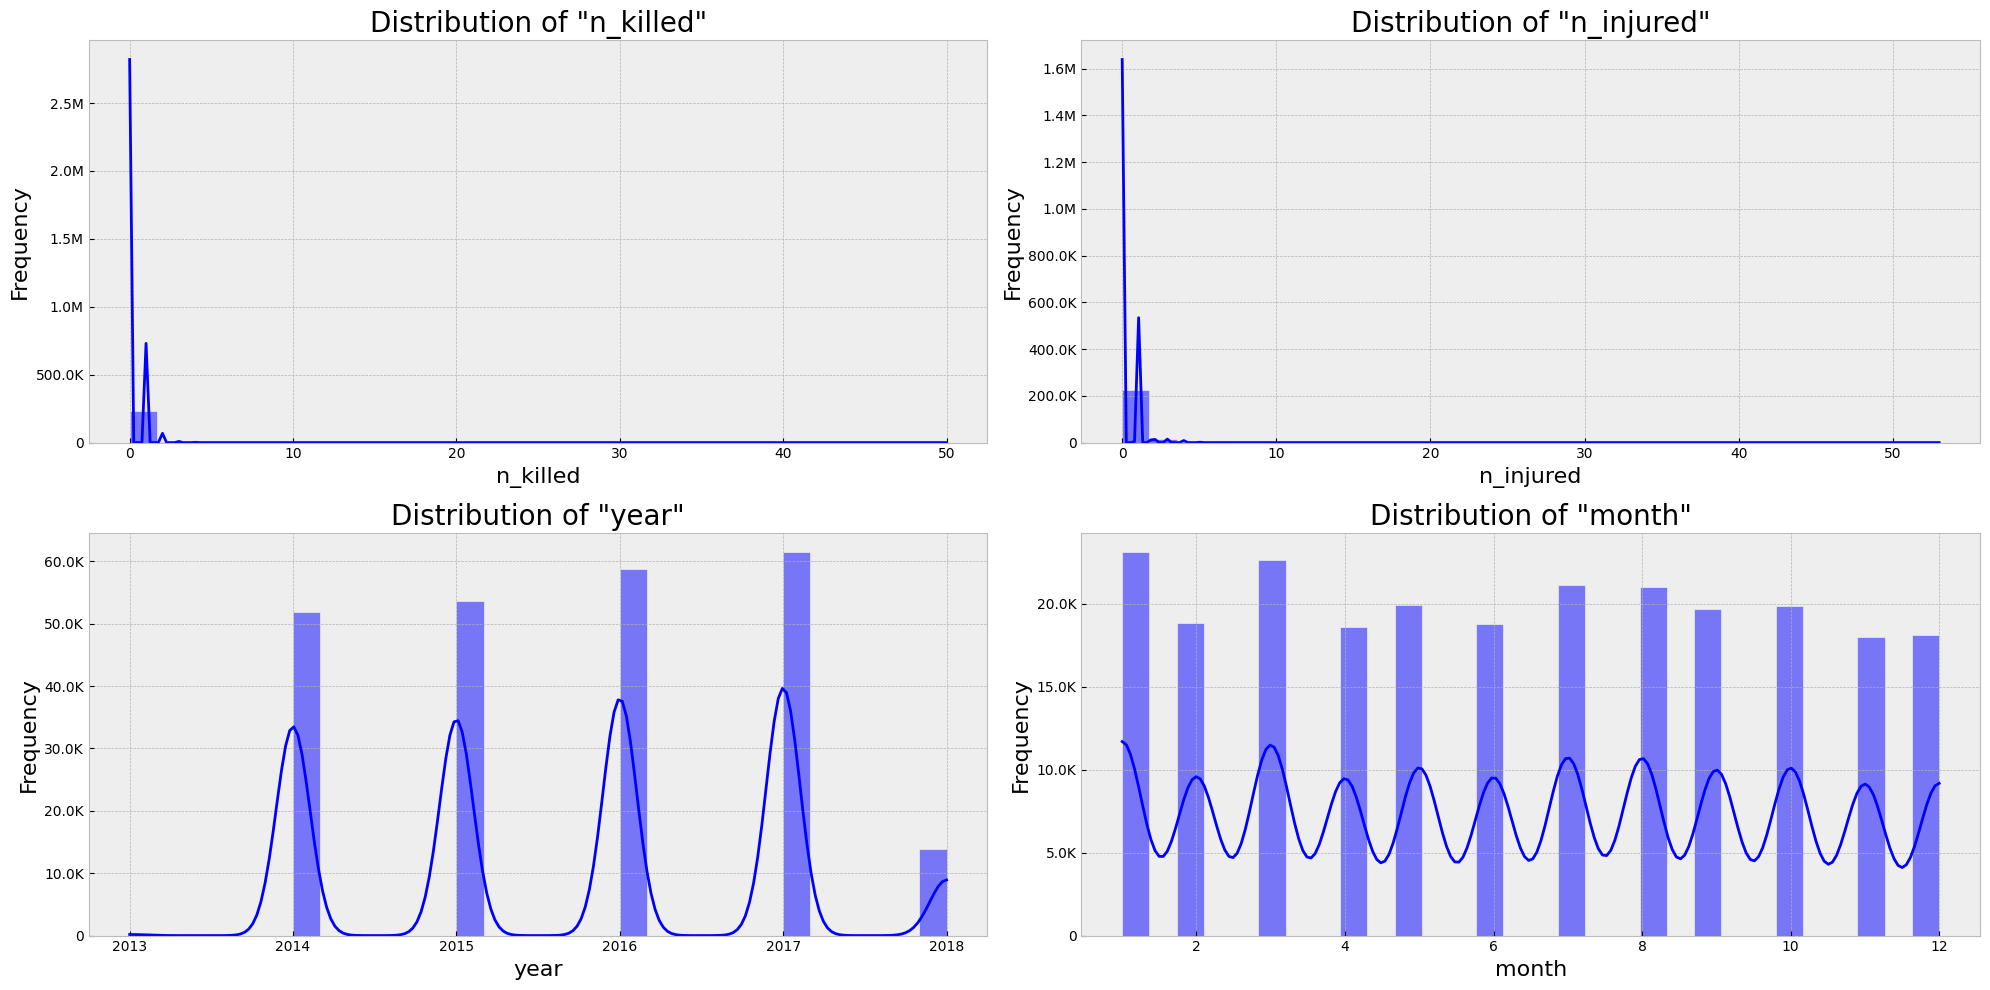

In [31]:
numerical_cols = ['n_killed', 'n_injured', 'year', 'month']


visualization.combined_plot(numerical_cols, visualization.dist_plot, fig_size=(20, 10))

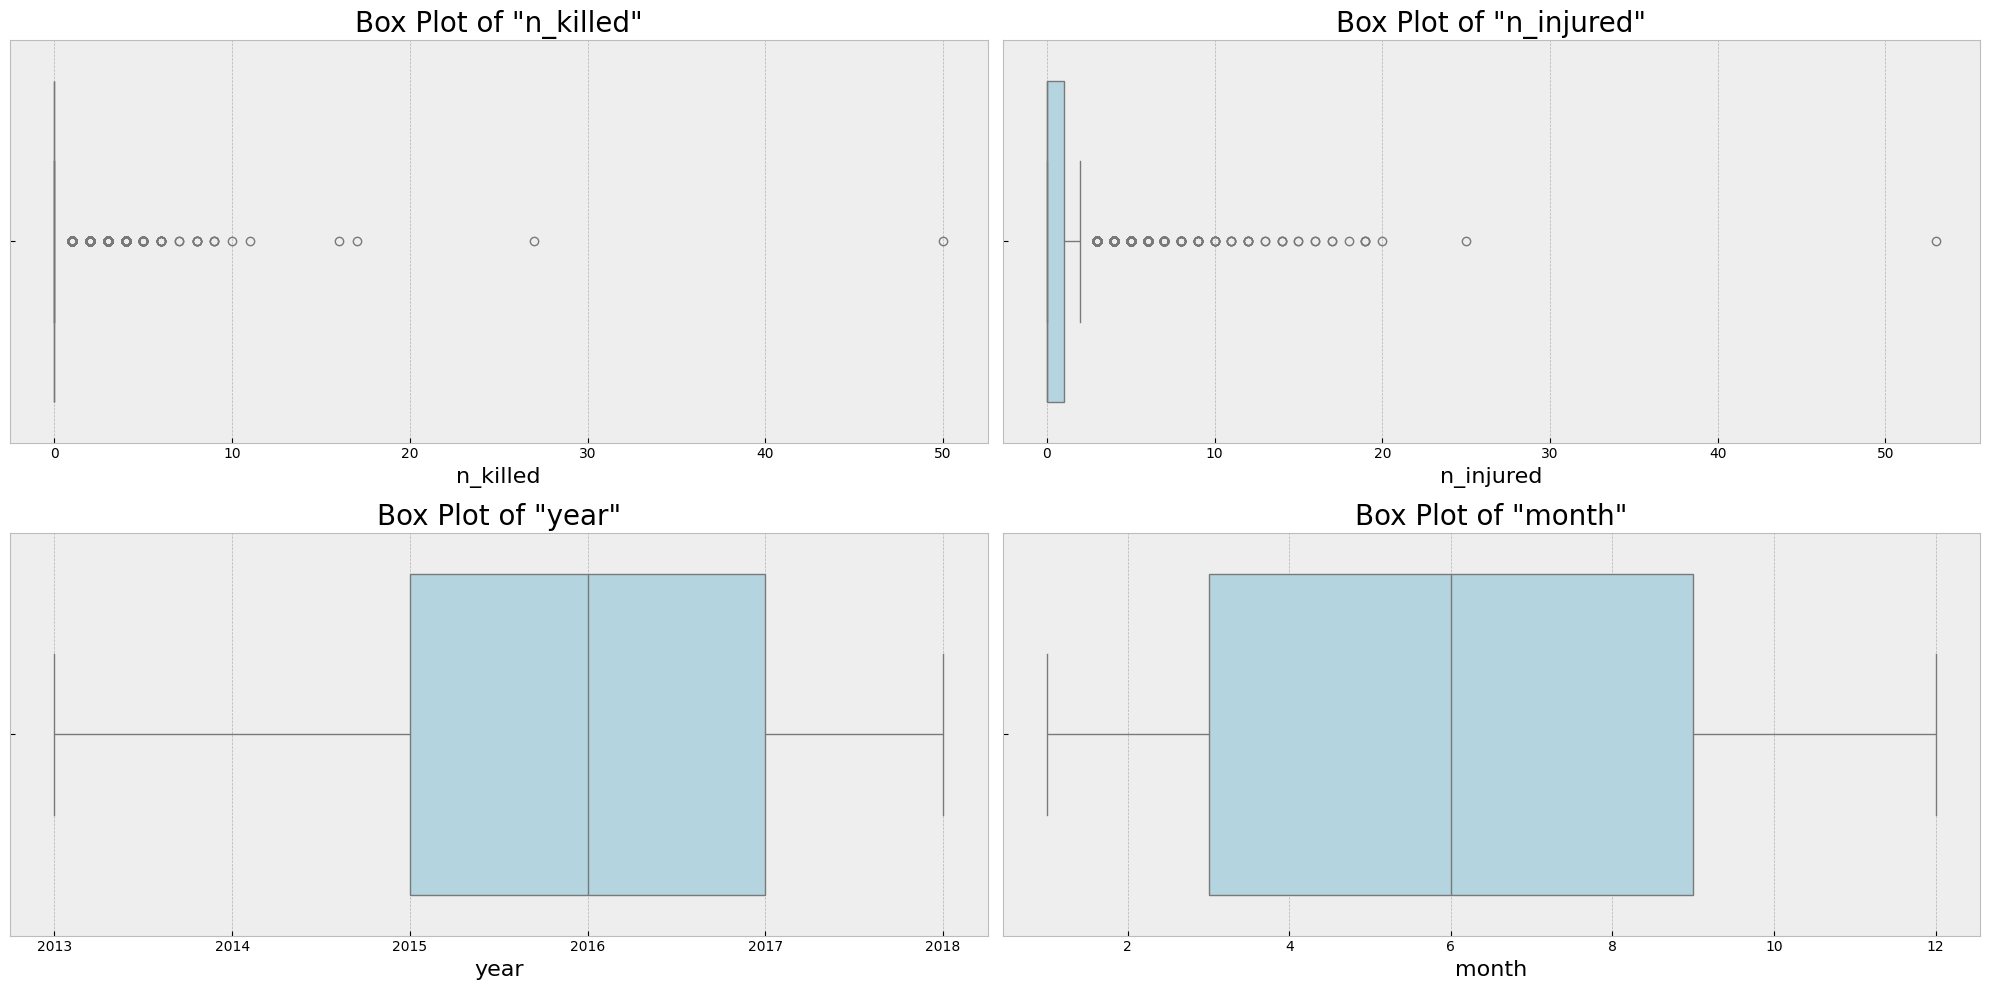

In [32]:
visualization.combined_plot(numerical_cols, visualization.box_plot, fig_size=(20, 10))

In [88]:
def analyze_participant_gender(df):
    """
    Analyzes participant demographics based on gender.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    # Sum the frequencies for each gender
    total_females = df['participant_gender_female_freq'].sum()
    total_males = df['participant_gender_male_freq'].sum()

    # Data for plotting
    genders = ['Female', 'Male']
    counts = [total_females, total_males]

    # Bar plot for total gender counts
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(genders, counts, color=['lightblue', 'salmon'])
    
    # Annotate value counts on bars
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval}', 
                    xy=(bar.get_x() + bar.get_width() / 2, yval), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

    ax.set_title('Total Participants by Gender', fontsize=16)
    ax.set_ylabel('Total Count', fontsize=13)
    ax.set_xlabel('Gender', fontsize=13)
    plt.show()

def stacked_bar_plot(df):
    """
    Stacked bar plot for participant gender and status.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    # Prepare data for each status
    data = {
        'Female': [
            df['participant_gender_female_freq'][df['participant_status_arrested_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_injured_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_killed_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_unharmed_freq'] > 0].sum(),
        ],
        'Male': [
            df['participant_gender_male_freq'][df['participant_status_arrested_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_injured_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_killed_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_unharmed_freq'] > 0].sum(),
        ],
    }

    # Creating DataFrame
    df_status = pd.DataFrame(data, index=['Arrested', 'Injured', 'Killed', 'Unharmed'])

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = df_status.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'salmon'])

    ax.set_title('Participant Status by Gender', fontsize=16)
    ax.set_ylabel('Number of Participants', fontsize=13)
    ax.set_xlabel('Status', fontsize=13)
    ax.legend(title='Gender', fontsize=10)

    # Annotate value counts on bars
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        ax.annotate(f'{int(height)}', 
                    xy=(x, y), 
                    ha='center', va='center', fontsize=10, color='black')

    plt.show()

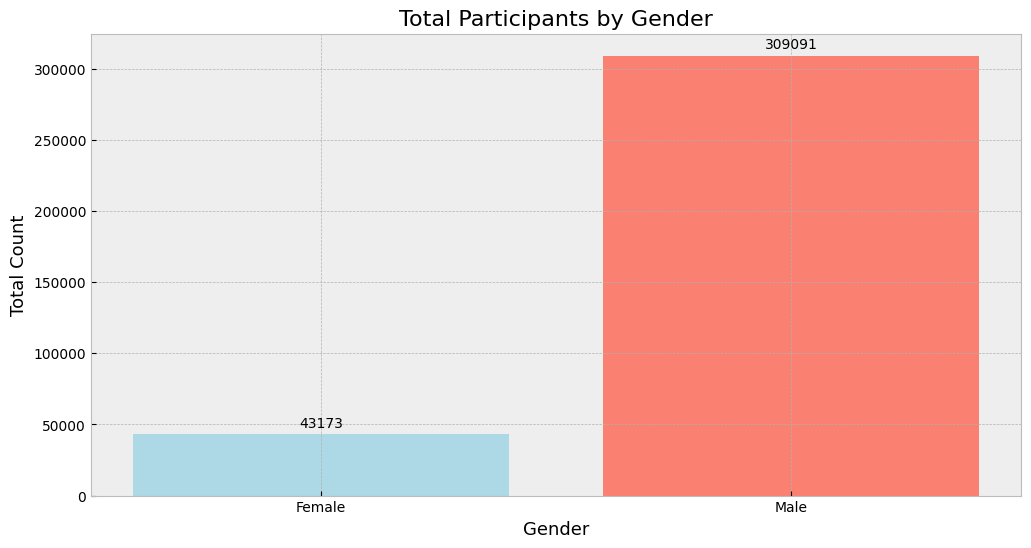

In [90]:
analyze_participant_gender(pandas_ip_df)

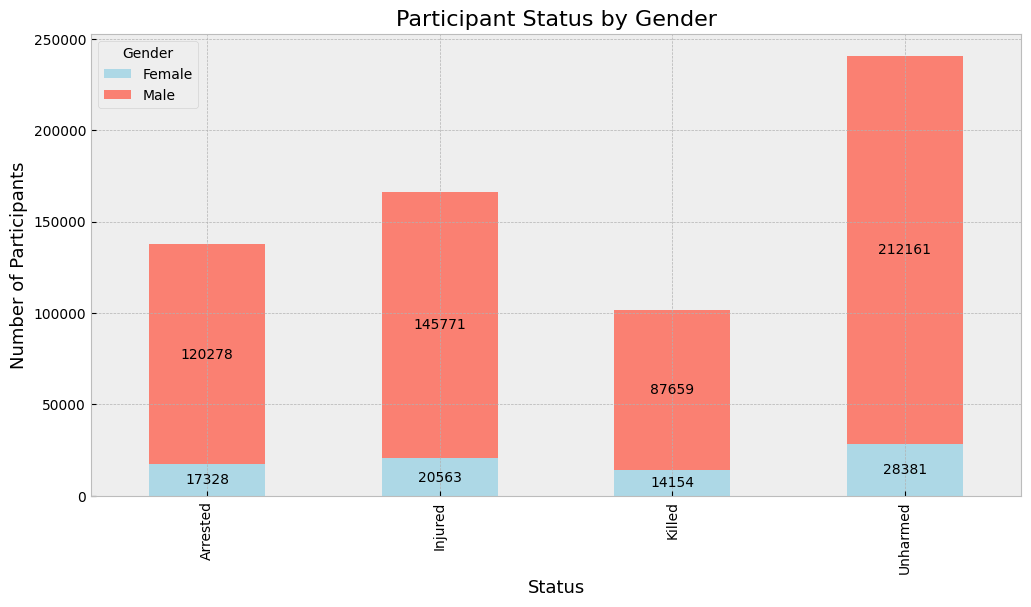

In [92]:
stacked_bar_plot(pandas_ip_df)

In [96]:
def status_frequency_plot(df):
    """
    Bar plot for participant statuses.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    status_counts = {
        'Arrested': df['participant_status_arrested_freq'].sum(),
        'Injured': df['participant_status_injured_freq'].sum(),
        'Killed': df['participant_status_killed_freq'].sum(),
        'Unharmed': df['participant_status_unharmed_freq'].sum(),
    }

    sorted_status_counts = dict(sorted(status_counts.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(sorted_status_counts.keys()), y=list(sorted_status_counts.values()), palette="Set2")
    plt.title('Total Participant Status Frequencies', fontsize=16)
    plt.xlabel('Status', fontsize=13)
    plt.ylabel('Total Frequency', fontsize=13)

    # Annotate values on bars
    for index, value in enumerate(sorted_status_counts.values()):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=12)

    plt.show()

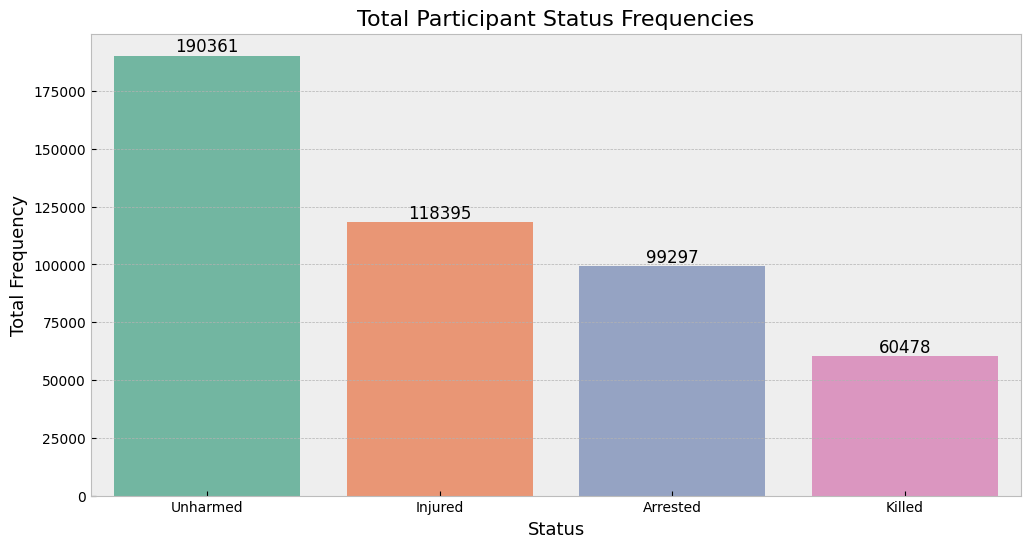

In [98]:
status_frequency_plot(pandas_ip_df)